# installation

In [ ]:
!pip install scikit-image pandas matplotlib tqdm  torchinfo tensorboard wandb scikit-learn

# Imports

In [41]:
import os
import wandb
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_sched
from torchinfo import summary
import torch.optim as optim
import random
import math
from tqdm import tqdm
import psutil


from typing import Dict

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Config

In [44]:
class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 100
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2A"
    DATA_PATH = os.path.join("Data", "Superresolution")
    PORTION_OF_DATA_FOR_TRAINING = 0.8
 

# Custom PyTorch Dataset

## Utils

In [29]:
def format(val : int) -> str:
    if val <= 1024:
        return f"{val}B"
    elif val <= 1024**2:
        return f"{round(val/1024, 2)}KB" 
    elif val <= 1024**3:
        return f"{round(val/(1024**2), 2)}MB" 
    return f"{round(val / (1024**3), 2)}GB"
    

memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 5.12GB


In [42]:
class DeepLenseSuperresolutionDataset(Dataset):

    def __init__(self, folder_path : str, randomize_dataset : bool = True,
                 preprocess_LR : bool = True, preprocess_HR : bool = True,
                 call_preprocess : bool = True,
                 data_limit=CONFIG.DATA_LIMIT, 
                 mean_LR = None, std_LR=None, 
                 mean_HR=None, std_HR=None) -> None:
        
        self.folder_path = folder_path
        self.class_folders = []
        self.preprocess_LR = preprocess_LR
        self.preprocess_HR = preprocess_HR

        folders = [os.path.join(self.folder_path, v) for v in os.listdir(CONFIG.DATA_PATH)]

        self.LR = [v for v in folders if v.endswith("LR")][0]
        self.HR = [v for v in folders if v.endswith("HR")][0]

        self.class_folders = [self.LR, self.HR]
        

        assert os.listdir(self.LR) == os.listdir(self.HR), "the number of samples in Low Resolution has to be the same as High Resolution"

        # get the samples 
        self.samples = os.listdir(self.LR)
        
        # limit the data (for faster prototyping )
        if data_limit > 0:
            self.samples = self.samples[:data_limit]
                
        # Datapoints
        self.LR_data = []
        self.HR_data = []
            
        pbar = tqdm(self.samples)
        for path in pbar:
            # load from the low resolution
            img1 = np.load(os.path.join(self.LR, path))
            self.LR_data.append(torch.Tensor(img1))            
            
            # load from the high resolution
            img2 = np.load(os.path.join(self.HR, path))
            self.HR_data.append(torch.Tensor(img2))
            
            pbar.set_description("Loading dataset : ")
        
        self.samples = np.array(self.samples)
        self.LR_data = torch.stack(self.LR_data)
        self.HR_data = torch.stack(self.HR_data)
        
        # calculate statistical values about the dataset 
        self.mean_HR = mean_HR
        if self.mean_HR is None:
            self.mean_HR = torch.mean(self.HR_data.reshape(-1))
            
        self.mean_LR = mean_LR
        if self.mean_LR is None:
            self.mean_LR = torch.mean(self.LR_data.reshape(-1))

        self.std_HR = std_HR
        if self.std_HR is None:
            self.std_HR = torch.std(self.HR_data.reshape(-1))

        self.std_LR = std_LR
        if self.std_LR is None:
            self.std_LR = torch.std(self.LR_data.reshape(-1))
            
        if call_preprocess:
            self.preprocess()            
        
        
        if randomize_dataset:
            self.randomize_dataset()

    def preprocess(self):
        
        pbar = tqdm(self.samples)
        
        for i, _ in enumerate(pbar):
            
            if self.preprocess_LR:
                self.LR_data[i] = self.preprocess_LR_func(self.LR_data[i])

            if self.preprocess_HR:
                self.HR_data[i] = self.preprocess_HR_func(self.HR_data[i])
            
            pbar.set_description("preprocessing :")
        
        
    # To override later (if any preprocessing is required)
    def preprocess_LR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        
    def preprocess_HR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        

    def randomize_dataset(self):
        idxes = np.arange(len(self.LR_data))
        random.shuffle(idxes)

        self.samples = self.samples[idxes]
        self.LR_data = self.LR_data[idxes]
        self.HR_data = self.HR_data[idxes]
    
    def preprocess_input(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.LR_data[idx], self.HR_data[idx]
    



In [46]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE)

Loading dataset : :   0%|          | 0/100 [00:00<?, ?it/s]

preprocessing :: 100%|██████████| 100/100 [00:00<00:00, 841.48it/s]


splitting into : 80 20
sizes of datasets : len(train)=80 len(val)=20


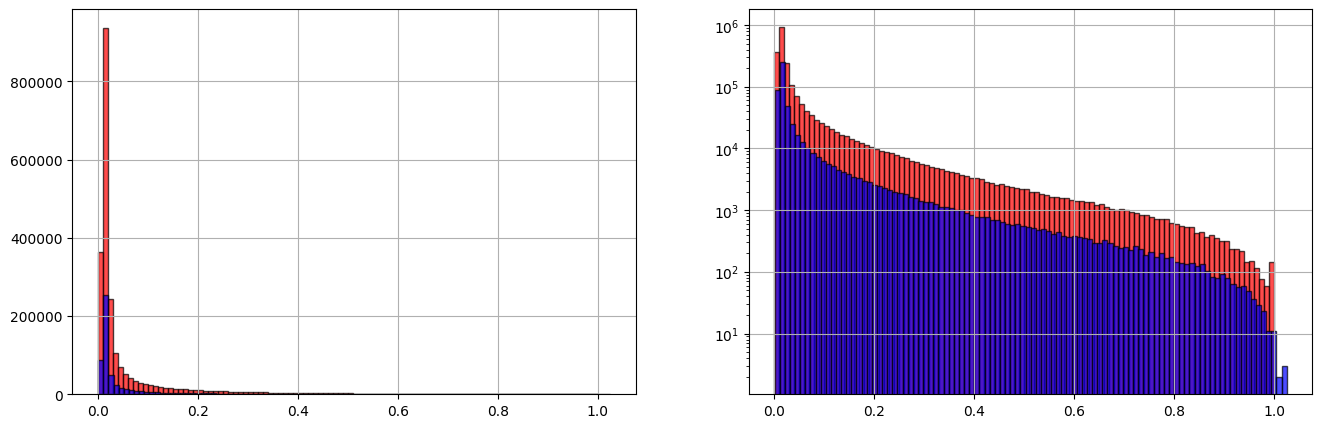

In [51]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [58]:
try:
    print(f"mean_LR = {ds.mean_LR.item()} std_LR = {ds.std_LR.item()}")
except Exception as e:
    print(f"mean_LR = {ds.mean_LR} std_LR = {ds.std_LR}")


try:
    print(f"mean_HR = {ds.mean_HR.item()} std_HR = {ds.std_HR.item()}")
except Exception as e:
    print(f"mean_HR = {ds.mean_HR} std_HR = {ds.std_HR}")
    

memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean_LR = 0.06162464618682861 std_LR = 0.11770287156105042
mean_HR = 0.06162464618682861 std_HR = 0.11766424030065536
RAM used : 5.37GB, RAM free : 289.67MB, memory used : 259.05MB


## see some of the data

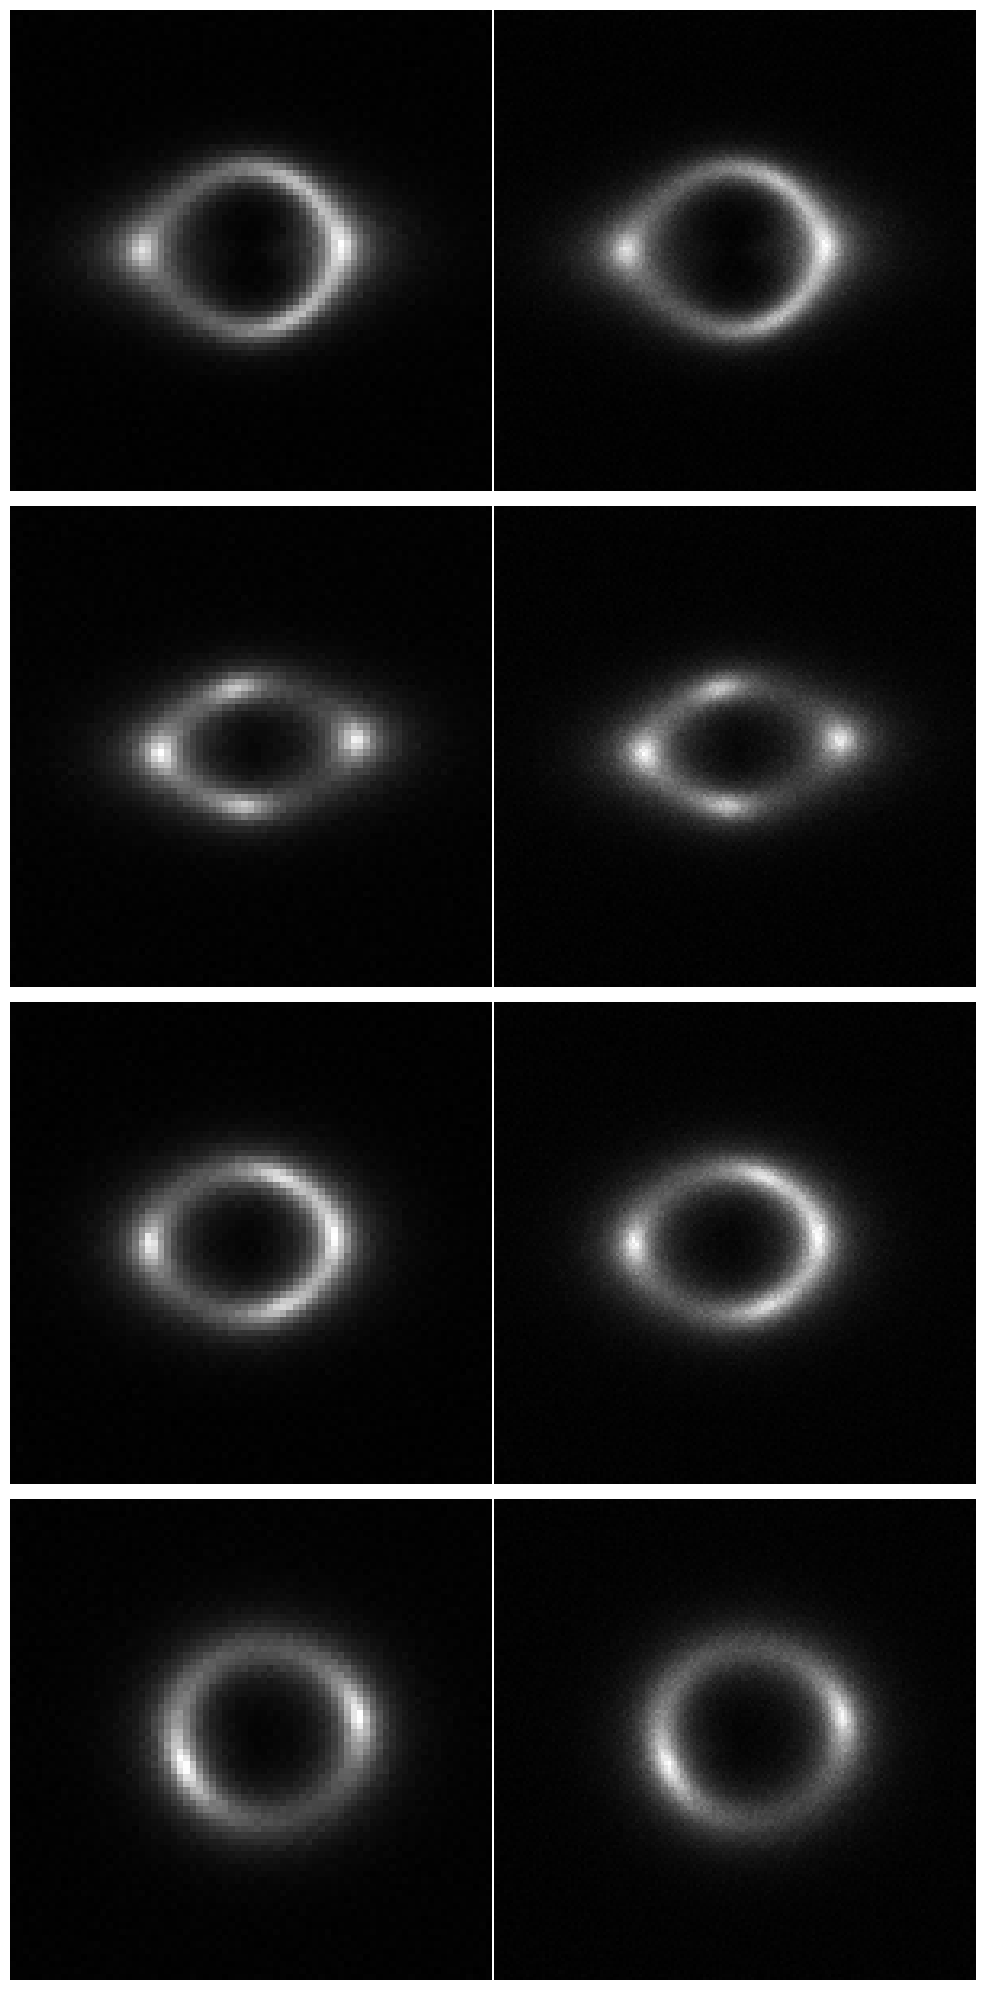

In [66]:
x, y = next(iter(val_loader))

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 5
fig, axes = plt.subplots(plot_size*plot_size, 2, figsize=(size_of_one * plot_size, size_of_one * len(x)))

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    if i % 2 == 0:
        img = x[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
    else:
        img = y[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

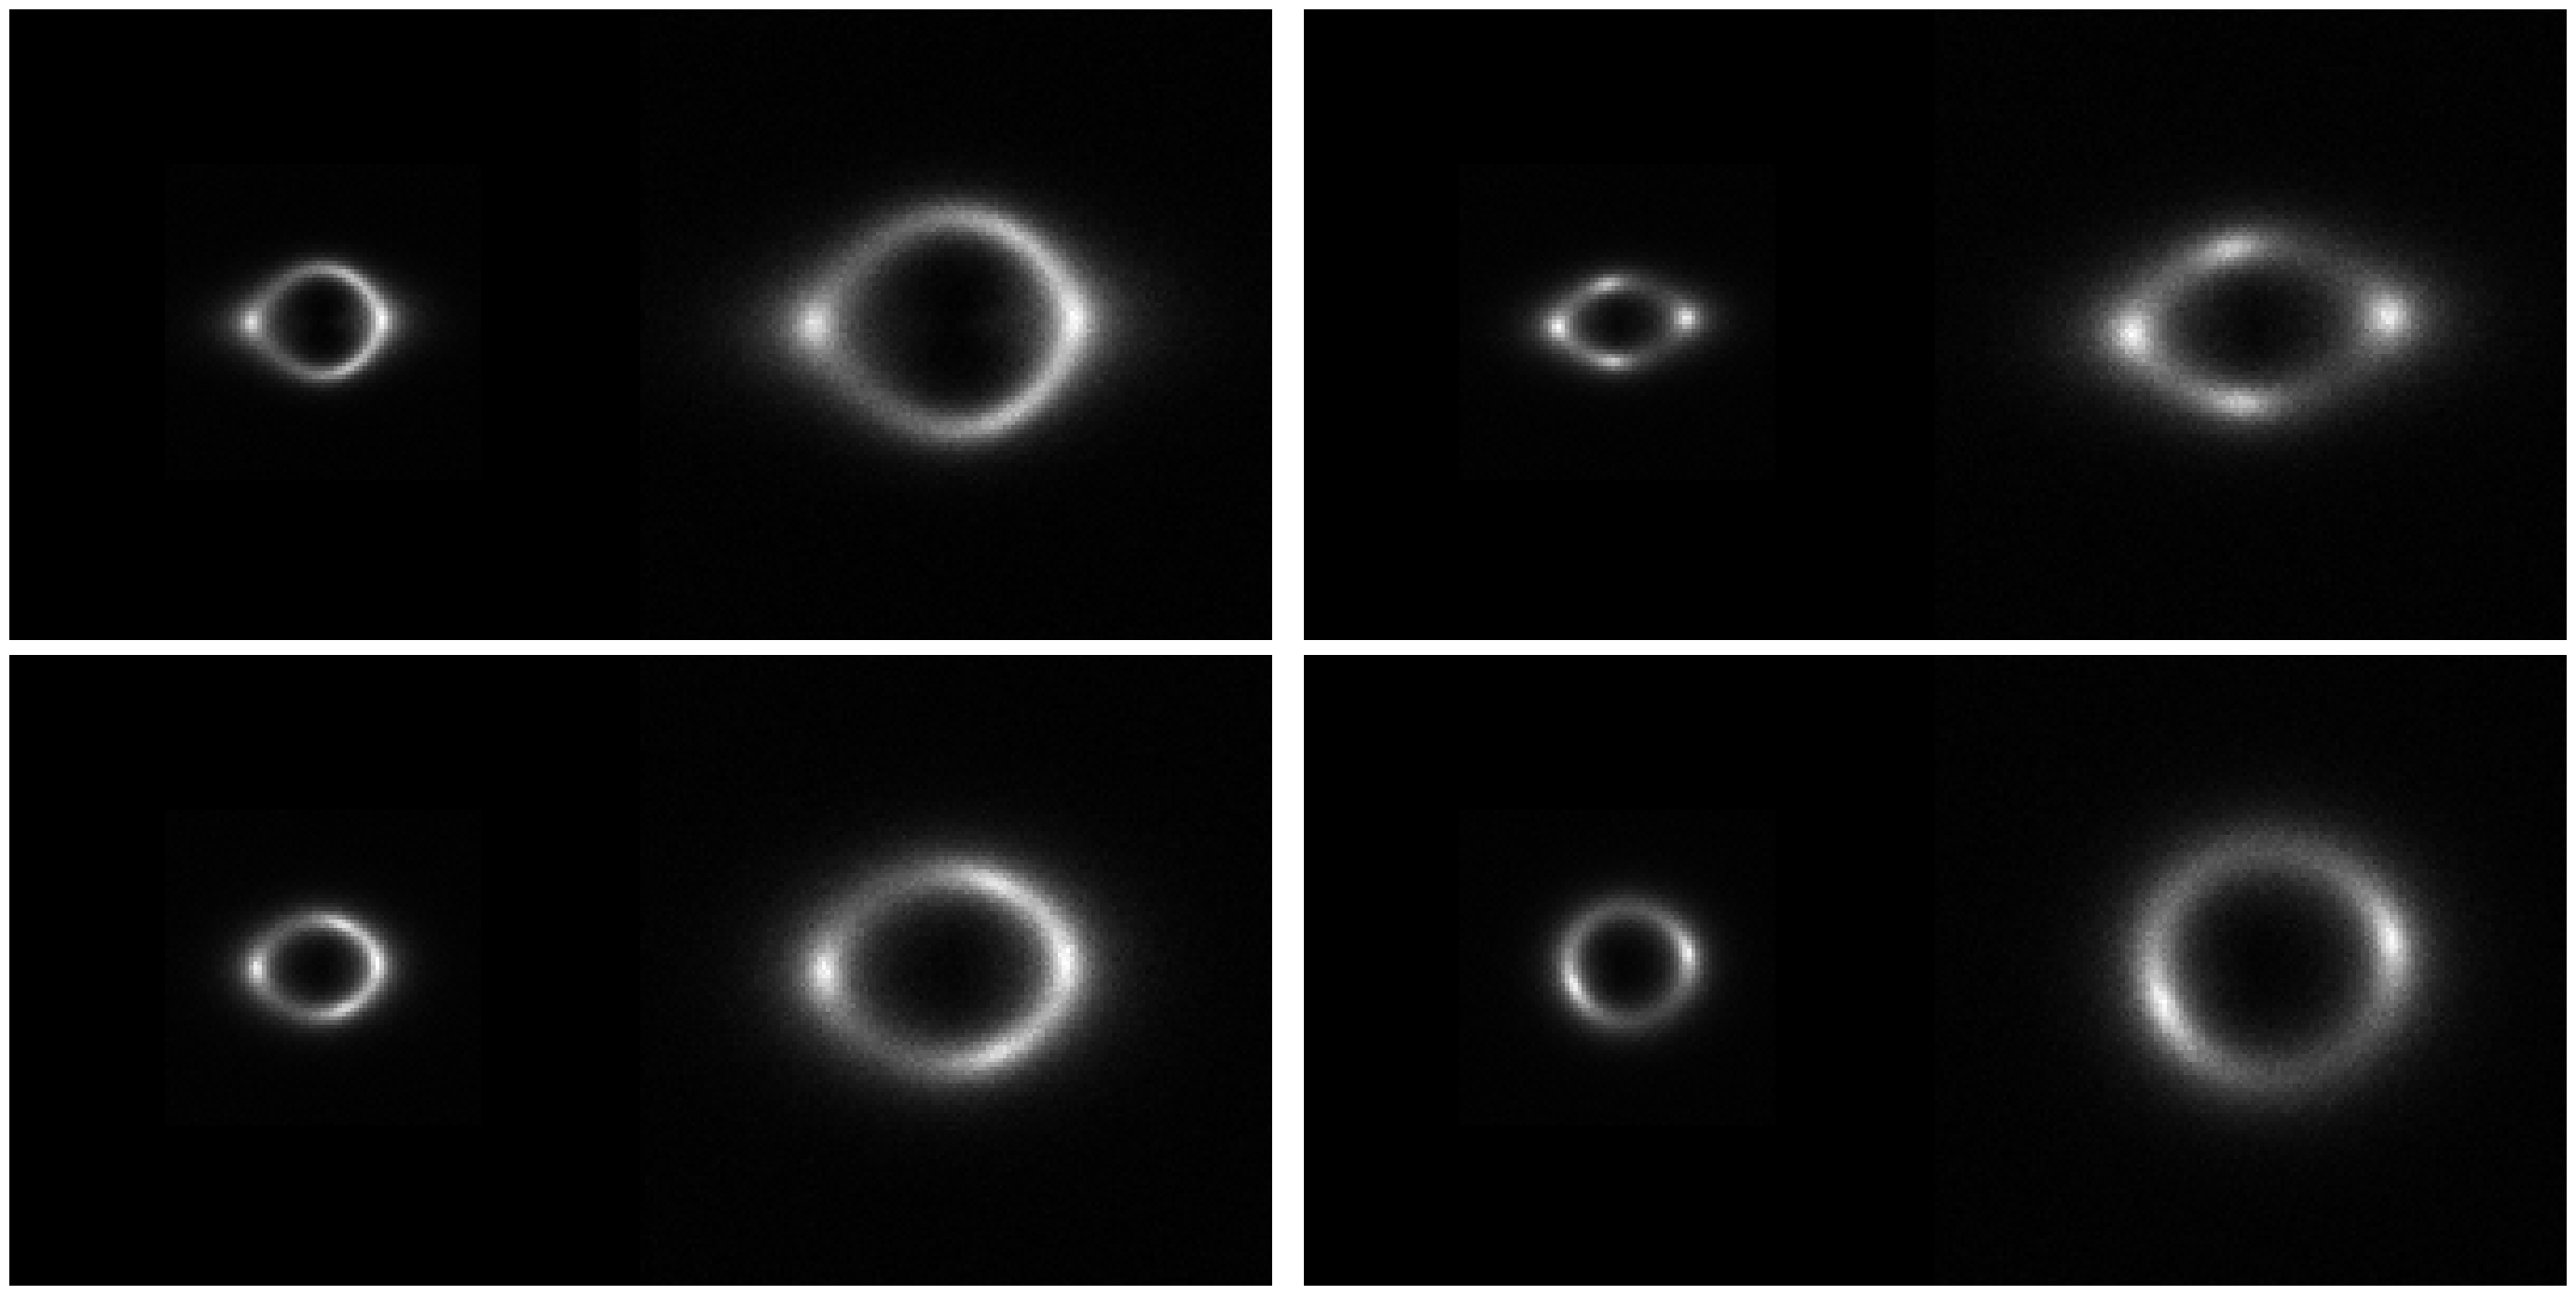

In [75]:
x, y = next(iter(val_loader))

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 7
fig, axes = plt.subplots(plot_size, plot_size, figsize=(2 * plot_size * size_of_one, plot_size * size_of_one))
center = True

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    _LR = x[i].numpy().transpose(1, 2, 0)
    HR = y[i].numpy().transpose(1, 2, 0)
    
    LR = np.zeros_like(HR)

    offset = 0
    if center:
        offset = _LR.shape[0] // 2

    LR[offset:(offset+_LR.shape[0]),offset:(offset+_LR.shape[1])] = _LR
    
    to_plot = np.concatenate([LR, HR], axis=1)
    
    ax.imshow(to_plot, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()